# AutoRec

This file contains an implementation by Robert McArthur of AutoRec 

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from framework.question_3.activation import Sigmoid, ReLU
from framework.question_3.realworld  import read_data
from framework.question_3.synthetic  import generate_synthetic
from framework.question_3.container  import Sequential
from framework.question_3.batcher    import MaskBatcher
from framework.question_3.linear     import Linear
from framework.question_3.linalg     import FrobeniusNorm
from framework.question_3.module     import Module
from framework.question_3.loss       import Loss, MSELoss, WeightedSumLoss

In [2]:
seed = 1094
np.random.seed(seed)

## Data Processing

### Data Reading

In [3]:
def get_valid_movies(file_location="ml-1m/ratings.dat"):
    valid_movies = {}
    with open(file_location, "r") as f:
        for line in f:
            movie_id = int(line.strip().split("::")[1])
            valid_movies[movie_id] = valid_movies.get(movie_id, 0) + 1
    
    return valid_movies


def read_movies(valid_movies, file_location="ml-1m/movies.dat"):
    id_indexes = {}
    index_movie_map = {}
    genre_ids = {}
    movie_genres = {}
    
    genre_id = 0
    movie_index = 0
    
    with open(file_location, "r", encoding="ANSI") as f:
        for line in f:
            movie_id, movie_name, genres = line.strip().split("::")
            movie_id = int(movie_id)
            
            if movie_id not in valid_movies:
                continue
            elif valid_movies[movie_id] < 10:
                continue
            
            genres = genres.split("|")
            
            id_indexes[movie_id] = movie_index
            movie_index += 1
            index_movie_map[id_indexes[movie_id]] = movie_name
            
            for genre in genres:
                if genre in genre_ids:
                    continue
                genre_ids[genre] = genre_id
                genre_id += 1
                       
            movie_genres[id_indexes[movie_id]] = set(map(lambda x: genre_ids[x], genres))
    return id_indexes, index_movie_map, genre_ids, movie_genres


def get_number_of_users(file_location="ml-1m/users.dat"):
    users = set()
    with open(file_location, "r") as f:
        for line in f:
            user_id = int(line.strip().split("::")[0])
            users.add(user_id)
    return len(users)


def read_ratings(movie_indexes, file_location="ml-1m/ratings.dat"):
    number_of_users = get_number_of_users()
    
    dataset = np.zeros((number_of_users, len(movie_indexes)))
    
    with open(file_location, "r") as f:
        for line in f:
            user_id, movie_id, rating, time_stamp = map(int, line.strip().split("::"))
            if movie_id not in movie_indexes:
                continue
            dataset[user_id-1, movie_indexes[movie_id]] = rating
    return dataset

In [4]:
valid_movies = get_valid_movies()
real_movie_indexes, movie_names, genre_ids, movie_genres = read_movies(valid_movies)

id_genres = {}
for genre in genre_ids:
    id_genres[genre_ids[genre]] = genre
user_movie_ratings = read_ratings(real_movie_indexes)

### Data Preprocessing

In [5]:
def generate_mask(dataset):
    mask = np.zeros(dataset.shape)
    mask[np.where(dataset != 0)] = 1
    return mask

In [6]:
def normalise_and_centre_unrated(dataset):
    """Ratings are between 1 and 5"""
    normalised = (dataset - 1) / 4
    normalised[np.where(dataset == 0)] = (np.mean(dataset[np.where(dataset != 0)]) - 1) / 4
    return normalised

In [7]:
mask = generate_mask(user_movie_ratings)
normalised_user_movie_ratings = normalise_and_centre_unrated(user_movie_ratings)

### Split into Train and Test Datasets

In [8]:
def train_test_split(dataset, mask, train_percent=0.8):
    perm = np.random.permutation(dataset.shape[0])
    
    train_idxs = perm[:round(dataset.shape[0] * train_percent)]
    test_idxs = perm[round(dataset.shape[0] * train_percent):]
    
    return dataset[train_idxs], dataset[test_idxs], mask[train_idxs], mask[test_idxs]

In [9]:
train, test, train_mask, test_mask = train_test_split(normalised_user_movie_ratings, mask)

## Autoencoder

In [10]:
class AERecommender(Module):
    def __init__(self, encoder, decoder):
        self.encoder = encoder
        self.decoder = decoder

        
    def init_weights(self, seed):
        self.encoder.init_weights(seed=seed)
        self.decoder.init_weights(seed=seed+1)

        
    def forward(self, x):
        super().forward(x)
        
        value = self.decoder.forward(self.encoder.forward(x))
        return value

    
    def backward(self, g_next_layer):
        back_grad = self.encoder.backward(self.decoder.backward(g_next_layer))
        return back_grad

    
    def encode(self, x):
        encoded = self.encoder.forward(x)
        return encoded
  

    def decode(self, z):
        decoded = self.decoder.forward(z)
        return decoded

    
    def recommend_rating(self, x):
        rating = self.decoder(self.encoder(x))
        return rating

    
    def update(self, learning_rate):
        self.encoder.update(learning_rate)
        self.decoder.update(learning_rate)

In [55]:
class ObservedLoss(Loss):
    def __init__(self, loss):
        self.loss = loss

        
    def forward(self, *xs):
        super().forward(xs)
        
        predicted, target, observed_mask = xs
        
        observed_loss = self.loss.forward(predicted * observed_mask, target * observed_mask) * observed_mask.size / observed_mask.sum()
        return observed_loss

    
    def backward(self, g_next_layer=1):
        predicted, target, observed_mask = self.input
        
        observed_back_grad = self.loss.backward(g_next_layer) * observed_mask.size / observed_mask.sum()
        return observed_back_grad

In [56]:
def loss_gen(encoder_linear, decoder_linear, reg_w=1e-3):
    obs_loss = ObservedLoss(MSELoss())
    reg_encoder = FrobeniusNorm(encoder_linear)
    reg_decoder = FrobeniusNorm(decoder_linear)
    
    specified_loss = WeightedSumLoss([
        (obs_loss, 1.0),
        (reg_encoder, reg_w/2),
        (reg_decoder, reg_w/2)
    ])
    
    return specified_loss

In [57]:
def movie_recommender(nmovies, hidden_size_1, hidden_size_2):
    encoder_linear = Linear(nmovies, hidden_size_1)
    encoder_linear_2 = Linear(hidden_size_1, hidden_size_2)
    decoder_linear = Linear(hidden_size_1, nmovies)
    decoder_linear_2 = Linear(hidden_size_2, hidden_size_1)
    
    my_encoder = Sequential([
        encoder_linear,
        Sigmoid(),
        encoder_linear_2,
        Sigmoid()
    ])
    my_decoder = Sequential([
        decoder_linear_2,
        Sigmoid(),
        decoder_linear,
        Sigmoid()
    ])

    autoencoder = AERecommender(
        encoder=my_encoder,
        decoder=my_decoder
    )

    return autoencoder, encoder_linear, decoder_linear

In [58]:
def train_movie_recommender(movie_train,
                            train_mask,
                            movie_test,
                            test_mask,
                            nmovies,
                            training_epoch=50,
                            batch_size=100,
                            learning_rate=5e-3,
                            reg_w=1e-3,
                            hidden_size_1=1,
                            hidden_size_2=1,
                            seed=None):
    autoencoder, encoder_linear, decoder_linear = movie_recommender(nmovies, hidden_size_1, hidden_size_2)
    loss_func = loss_gen(encoder_linear, decoder_linear, reg_w=reg_w)
    
    make_batch = lambda: MaskBatcher(movie_train, train_mask,
                                     batch_size=batch_size)
    
    train_history = []
    test_history = []
    
    # Initialise
    autoencoder.init_weights(seed=seed)
    
    
    for e in range(training_epoch):
        print(f"EPOCH {e+1}/{training_epoch}")
        for xs, masks in make_batch()(seed=seed+e):
            reconstructed = autoencoder.forward(xs)
            loss_val      = loss_func.forward(reconstructed, xs, masks)
            grad          = loss_func.backward()
#             print("GRAD", grad[2832])
            autoencoder.backward(grad)
            loss_func.update(learning_rate)
            autoencoder.update(learning_rate)

            train_history.append(loss_val)
            
            test_predicted = autoencoder.forward(movie_test)
            test_loss      = loss_func.forward(test_predicted, movie_test, test_mask)
            test_history.append(test_loss)
            

    return autoencoder, train_history, test_history

In [59]:
auto_rec, train_history, test_history = train_movie_recommender(train, train_mask, test, test_mask, normalised_user_movie_ratings.shape[1], training_epoch=10, batch_size=500, learning_rate=2.8, reg_w=0.000025, hidden_size_1=55, hidden_size_2=45, seed=seed)

EPOCH 1/10
1630000 1630000
3938080 3938080
1630000 1630000
3938080 3938080
1630000 1630000
3938080 3938080
1630000 1630000
3938080 3938080
1630000 1630000
3938080 3938080
1630000 1630000
3938080 3938080
1630000 1630000
3938080 3938080
1630000 1630000
3938080 3938080


KeyboardInterrupt: 

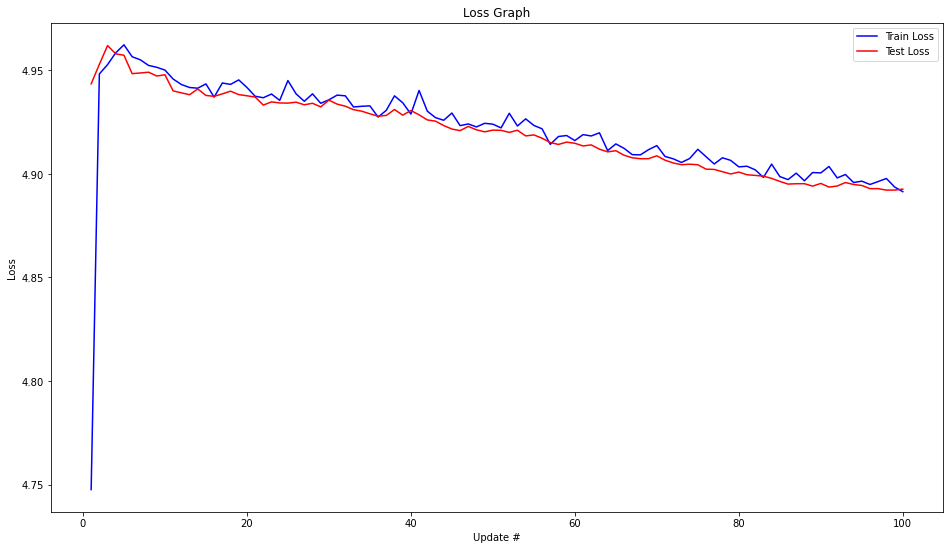

[4.747653793937082, 4.948229870174141, 4.952740352269458, 4.958452049875965, 4.962305200420952, 4.956544193864454, 4.9550561806951325, 4.952353028839486, 4.951455863487798, 4.950100191685829, 4.945779188387937, 4.943153716056826, 4.941701628669376, 4.941357850388425, 4.943432234548744, 4.937059979977193, 4.943873691976229, 4.943198140999227, 4.945359378148938, 4.941731170216473, 4.937479758859694, 4.93675552019076, 4.938545791863476, 4.9354745594088545, 4.945044140806921, 4.938613501574149, 4.935039868270438, 4.938628208261104, 4.934081506443318, 4.935751849854292, 4.938016333733469, 4.937679495688558, 4.932297647283502, 4.932631124193545, 4.932825273386859, 4.92743150007046, 4.930686674776638, 4.937663590833527, 4.934353546931083, 4.928878823553548, 4.94028174181819, 4.930294659894116, 4.9271475269856175, 4.925880144646706, 4.92937495188106, 4.92329317488146, 4.924105988862296, 4.922670192913393, 4.924422164583079, 4.923997282339071, 4.922195955308387, 4.929271506388684, 4.92311185892

In [40]:
plt.figure(figsize=(16,9))
plt.plot(np.arange(1, 1 + len(train_history)), train_history, c="b", label="Train Loss")
plt.plot(np.arange(1, 1 + len(test_history)), test_history, c="r", label="Test Loss")
plt.xlabel("Update #")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Graph")
plt.show()
# print(test_history)
print(train_history)

In [41]:
x = auto_rec.encode(normalised_user_movie_ratings[0,:])
print(x)
y = auto_rec.decode(auto_rec.encode(normalised_user_movie_ratings[0,:]))
print(y)
print(np.max(y))
print(np.argmax(y))
print(np.max(x))

[[9.99740355e-01 1.21969157e-17 1.00000000e+00 9.99803043e-01
  8.75651076e-27 3.17439049e-03 5.47834644e-04 8.75651076e-27
  9.97567236e-01 9.95484661e-01 9.99992829e-01 1.47251999e-04
  8.75651076e-27 1.00000000e+00 9.99092809e-01 1.00000000e+00
  2.87468784e-10 1.00000000e+00 1.00000000e+00 1.00000000e+00
  9.99898634e-01 9.99364604e-01 1.57733020e-10 9.99923992e-01
  8.75651076e-27 1.32399652e-03 1.00000000e+00 9.99989564e-01
  2.85618147e-12 2.32692960e-07 9.99987036e-01 2.66136314e-17
  1.00000000e+00 1.83842903e-16 8.75651076e-27 9.99922124e-01
  9.96189718e-01 9.99643231e-01 3.59673919e-03 4.37915009e-16
  1.00000000e+00 9.99999962e-01 8.49634420e-11 6.56557665e-09
  1.00000000e+00]]
[[1.         0.99277433 0.93176312 ... 0.7377731  0.78351108 0.99860112]]
1.0
232
1.0


In [42]:
print(train_history)
print(mask[:,3].sum())
print(auto_rec.encode(normalised_user_movie_ratings[0,:]))
print(auto_rec.decode(auto_rec.encode(normalised_user_movie_ratings[0,:])))
def predict_all(dataset, mask, autoencoder):
    for i, (user, user_mask) in enumerate(zip(dataset, mask)):
        predicted = autoencoder.recommend_rating(user)
        best_movie = np.argmax(predicted * (1 - user_mask))
        print(predicted)
        print(predicted.shape)
        print(i, movie_names[best_movie],"HERE", predicted[:,best_movie], best_movie)
predict_all(normalised_user_movie_ratings, mask, auto_rec)

[4.747653793937082, 4.948229870174141, 4.952740352269458, 4.958452049875965, 4.962305200420952, 4.956544193864454, 4.9550561806951325, 4.952353028839486, 4.951455863487798, 4.950100191685829, 4.945779188387937, 4.943153716056826, 4.941701628669376, 4.941357850388425, 4.943432234548744, 4.937059979977193, 4.943873691976229, 4.943198140999227, 4.945359378148938, 4.941731170216473, 4.937479758859694, 4.93675552019076, 4.938545791863476, 4.9354745594088545, 4.945044140806921, 4.938613501574149, 4.935039868270438, 4.938628208261104, 4.934081506443318, 4.935751849854292, 4.938016333733469, 4.937679495688558, 4.932297647283502, 4.932631124193545, 4.932825273386859, 4.92743150007046, 4.930686674776638, 4.937663590833527, 4.934353546931083, 4.928878823553548, 4.94028174181819, 4.930294659894116, 4.9271475269856175, 4.925880144646706, 4.92937495188106, 4.92329317488146, 4.924105988862296, 4.922670192913393, 4.924422164583079, 4.923997282339071, 4.922195955308387, 4.929271506388684, 4.92311185892

In [43]:
def genres_for_user(user_index, dataset, movie_genres, id_genres):
    movies_watched = dataset[user_index]
    
    genre_scores = np.zeros((len(id_genres),))
    
    for index in np.where(movies_watched != 0)[0]:
        for genre_id in movie_genres[index]:
            genre_scores[genre_id] += movies_watched[index] - 3
    plt.figure(figsize=(21,8))
    plt.bar(np.arange(genre_scores.size) , genre_scores)
    plt.title("Distribution of Genres Watched for User " + str(user_index + 1))
    plt.xticks(np.arange(genre_scores.size) , [id_genres[i] for i in range(genre_scores.size)])
    plt.ylabel("Genre Frequency")
    plt.plot()

def recommended_genre_movie(user_index, auto_rec, normalised_dataset, mask, movie_genres, id_genres, movie_names):
    movie_scores = auto_rec.recommend_rating(normalised_dataset[user_index])
    
    best_movie = np.argmax(movie_scores * (1 - mask[user_index]))
    best_movie_name = movie_names[best_movie]
    
    genre_scores = np.zeros((len(id_genres),))
    
    for genre_id in movie_genres[best_movie]:
        genre_scores[genre_id] += 1
    
    plt.figure(figsize=(21,8))
    plt.bar(np.arange(genre_scores.size) , genre_scores)
    plt.title("Genres for the Recommended Movie to User " + str(user_index + 1) + ", " + best_movie_name)
    plt.xticks(np.arange(genre_scores.size) , [id_genres[i] for i in range(genre_scores.size)])
    plt.ylabel("Genre")
    plt.plot()

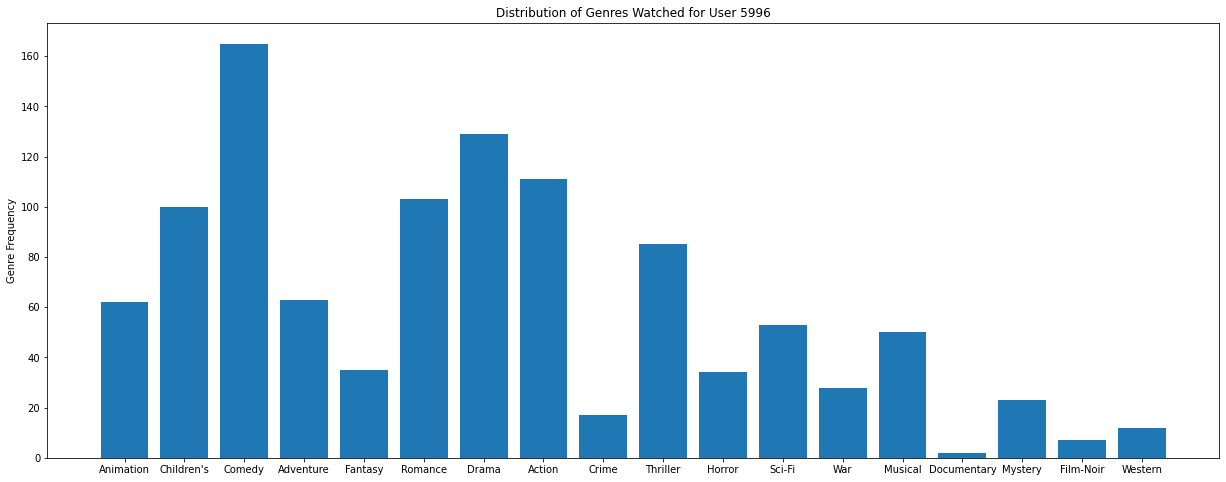

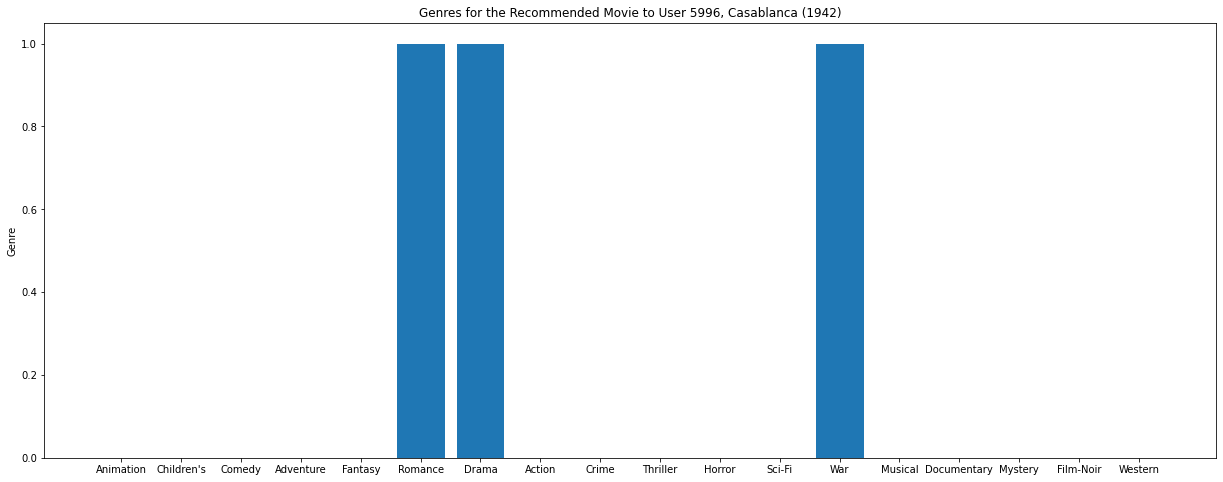

In [44]:
user_index = 5995
genres_for_user(user_index, user_movie_ratings, movie_genres, id_genres)
recommended_genre_movie(user_index, auto_rec, normalised_user_movie_ratings, mask, movie_genres, id_genres, movie_names)